# Phased Arrays - Steering and the Antenna Pattern

Part 1 of my phased array series covers adjusting phase weights to electronically steer a beam, computing an array's antenna pattern (mostly focusing on the array factor portion), and the boundary between the near and far fields.

This notebook lets you play with the concepts discussed in the video.

> Provided as supplemental material for [Marshall Bruner](https://tinyurl.com/marshall-bruner-yt)'s [animated introduction to phased arrays](https://tinyurl.com/phased-array-part1-vid).

- [GitHub](https://tinyurl.com/github-nb)
- [YouTube](https://tinyurl.com/marshall-bruner-yt-nb)
- [Buy me a coffee](https://tinyurl.com/mbrf-buy-me-a-coffee)

![thumbnail](https://drive.google.com/uc?id=1WEInRsNEe4GyfigRqNqloQhXlqTvD26P)

## References
1. [Robert Mailloux, Phased Array Antenna Handbook, Third Edition , Artech, 2017. (book)](https://tinyurl.com/mailloux-book)
1. [Phased Array Antenna Patterns—Part 1: Linear Array Beam Characteristics and Array Factor - Analog Devices (article)](https://tinyurl.com/adi-phased-arrays-part1)
1. [Exploring RF Beamforming: A Practical Hardware Approach - Jon Kraft (video)](https://tinyurl.com/jon-beamforming-video)
1. [Adaptive Antennas and Phased Arrays — Online Course - MIT LL (course slides)](https://tinyurl.com/mit-phased-arrays)
1. [Mathwork's incredible video series on phased arrays (video)](https://tinyurl.com/mathworks-phased-arrays)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, pi
from scipy import signal
from matplotlib import cm

%matplotlib inline
plt.style.use("ggplot")
# plt.rcParams.update(
#     {
#         "text.usetex": True,
#         "font.family": "typeface",
#     }
# )  # Makes plotting slower but prettier (requires LaTeX installed)

## Near / Far Field Boundary

The following calculations will be assumed to be done in the far field, or where the propagating wave resembles a plane wave.
The boundary between the near and far fields are not definitive, but the *Fraunhofer distance* is a commonly used approximation:

\begin{equation}
    \Large d_F = \frac{2 D^2}{\lambda}
\end{equation}

where $D$ is the largest dimension of the antenna, and $d_F$ must also satisfy the following constraints


\begin{equation}
    \Large d_F \gg \lambda \\
    \Large d_F \gg D \\
\end{equation}

In [ ]:
D_x = 1
D_y = 0.5

f = 10e9
wavelength = c / f


D = max(D_x, D_y)

d_f = 2 * D**2 / wavelength
print(
    f"For a {D_x:.1f}x{D_y:.1f} m^2 antenna at a frequency of {f / 1e9:.1f} GHz, the Fraunhofer distance would be: d_f = {d_f:.2f} m"
)

For a 1.0x0.5 m^2 antenna at a frequency of 10.0 GHz, the Fraunhofer distance would be: d_f = 66.71 m


## Setup

In [ ]:
f_0 = 10e9  # center frequency for computing phase shifts (GHz)
wavelength_0 = c / f_0  # m
k_0 = 2 * pi / wavelength_0  # wave number
d_x = wavelength_0 / 2  # element spacing (m)

N = 8  # number of elements

steering_angle = 0
u_0 = np.sin(steering_angle * pi / 180)

In [ ]:
theta = np.linspace(-pi, pi, 1000)  # theta values to plot over
u = np.sin(theta)  # theta in sine space

## Steering

![screenshot from video](https://drive.google.com/uc?id=1WTK9FVFyCPeo-SqvMC5Dd3rVR_UPiJI2)

In [ ]:
scan_to = 20 # degrees
scan_to_rad = scan_to * pi / 180 # radians

phase_shift = d_x * np.sin(scan_to_rad) * 2 * pi / wavelength_0 # phase shift in radians
phase_shift_deg = phase_shift * 180 / pi # phase shift in degrees

print(f"To scan to {scan_to} degrees off boresight, with an operating frequency of {f_0/1e9:.2f} GHz, a phase shift of {phase_shift_deg:.2f} degrees is needed")

To scan to 20 degrees off boresight, with an operating frequency of 10.00 GHz, a phase shift of 61.56 degrees is needed


## Antenna Pattern

## Approximation Method

Using:

\begin{equation}
    \Large F(u) = \frac{\sin{[N \pi d_x (u - u_0) / \lambda_0]}}{N \sin{[\pi d_x (u - u_0) / \lambda_0]}}
\end{equation}

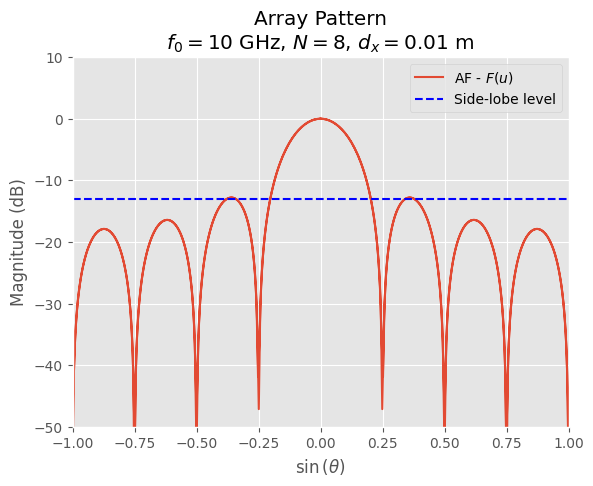

In [ ]:
AF = np.sin(N * pi * d_x * (u - u_0) / wavelength_0) / (
    N * np.sin(pi * d_x * (u - u_0) / wavelength_0)
)

fig, ax = plt.subplots()
ax.plot(u, 20 * np.log10(np.abs(AF)), label="AF - $F(u)$")
ax.set_xlim(-1, 1)
ax.set_ylim(-50, 10)
ax.axhline(-13, c="b", linestyle="--", label="Side-lobe level")
ax.set_xlabel(r"$\sin{(\theta)}$")
ax.set_ylabel(r"Magnitude (dB)")
ax.set_title(
    f"Array Pattern\n$f_0 = {f_0 / 1e9:.0f}$ GHz, $N = {N}$, $d_x = {d_x:.2f}$ m"
)
ax.legend()
plt.show()

## Complex Exponential Method

Using:

\begin{equation}
    \Large E(\theta) = f(\theta, \phi) \sum \lvert a_n \rvert \exp{\left[ j k_0  n d_x \left( u - u_0 \right) \right]}
\end{equation}

In [ ]:
def compute_af(weights):
    n = np.arange(weights.size)
    AF = np.sum(
        weights[:, None] * np.exp(1j * n[:, None] * d_x * k_0 * (u - u_0)), axis=0
    )
    AF /= AF.max()
    return AF

In [ ]:
fnbw = 2 * wavelength_0 / (N * d_x)
print(f"First null beamwidth in sine space: {fnbw}")
print(f"First null beamwidth in radians: {fnbw * pi:.2f}")

First null beamwidth in sine space: 0.5
First null beamwidth in radians: 1.57


In [ ]:
def sinc_element_pattern(theta, phi, L, W, wavelength_0):
    k = 2 * np.pi / wavelength_0
    E_theta = np.sinc(k * L / 2 * np.sin(theta) * np.cos(phi))
    E_phi = np.sinc(k * W / 2 * np.sin(theta) * np.sin(phi))
    return np.abs(E_theta * E_phi)

In [ ]:
epsilon_r = 2.2  # relative permittivity of substrate
h = 1.6e-3  # substrate height (m)

epsilon_eff = (epsilon_r + 1) / 2 + (epsilon_r - 1) / 2 * (
    1 + 12 * h / wavelength_0
) ** -0.5
L = wavelength_0 / (2 * np.sqrt(epsilon_eff))  # patch length (m)
W = wavelength_0 / 2 * np.sqrt(2 / (epsilon_r + 1))  # patch width (m)

EP = sinc_element_pattern(theta, 0, L, W, wavelength_0)

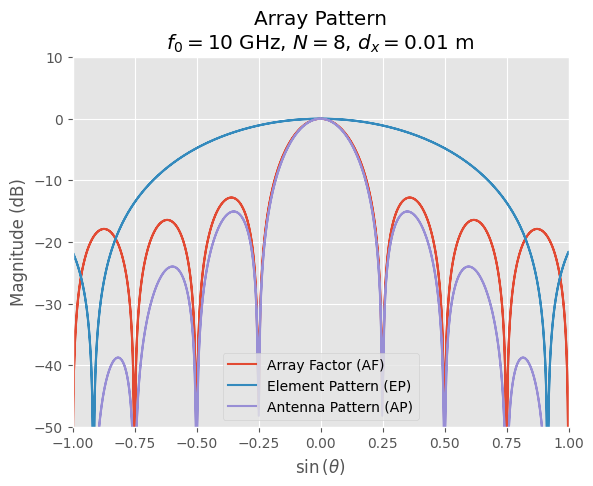

In [ ]:
elems = np.ones(N)
n = np.arange(N)
AF = np.sum(np.exp(1j * n[:, None] * d_x * k_0 * (u - u_0)), axis=0) / N


AP = AF * EP

fig, ax = plt.subplots()
ax.plot(u, 20 * np.log10(np.abs(AF)), label="Array Factor (AF)")
ax.plot(u, 20 * np.log10(np.abs(EP)), label="Element Pattern (EP)")
ax.plot(u, 20 * np.log10(np.abs(AP)), label="Antenna Pattern (AP)")
ax.set_xlim(-1, 1)
ax.set_ylim(-50, 10)
# ax.axhline(-13, c="b", linestyle="--", label="Side-lobe level")
ax.set_xlabel(r"$\sin{(\theta)}$")
ax.set_ylabel(r"Magnitude (dB)")
ax.set_title(
    f"Array Pattern\n$f_0 = {f_0 / 1e9:.0f}$ GHz, $N = {N}$, $d_x = {d_x:.2f}$ m"
)
ax.legend()
plt.show()

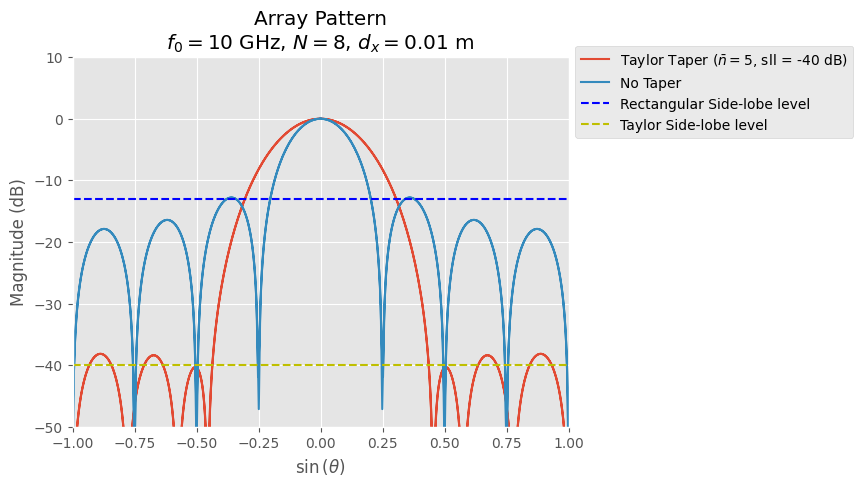

In [ ]:
weights_rect = np.ones(N)
nbar = 5
sll = 40
weights_taylor = signal.windows.taylor(N, nbar=nbar, sll=sll)
AF_rect = compute_af(weights_rect)
AF_taylor = compute_af(weights_taylor)


fig, ax = plt.subplots()
ax.plot(
    u,
    20 * np.log10(np.abs(AF_taylor)),
    label=f"Taylor Taper ($\\bar{{n}} = {nbar}$, sll = {-sll} dB)",
)
ax.plot(
    u,
    20 * np.log10(np.abs(AF_rect)),
    label=f"No Taper",
)
ax.set_xlim(-1, 1)
ax.set_ylim(-50, 10)
ax.axhline(-13, c="b", linestyle="--", label="Rectangular Side-lobe level")
ax.axhline(-40, c="y", linestyle="--", label="Taylor Side-lobe level")
ax.set_xlabel(r"$\sin{(\theta)}$")
ax.set_ylabel(r"Magnitude (dB)")
ax.set_title(
    f"Array Pattern\n$f_0 = {f_0 / 1e9:.0f}$ GHz, $N = {N}$, $d_x = {d_x:.2f}$ m"
)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1.05))
plt.show()

## 2D

The equation in 2 dimensions, $u$ and $v$, becomes

\begin{equation}
    \Large F(\theta, \phi) = \sum_{m}^{M} \sum_{n}^{N} \lvert a_{m,n} \rvert \exp{\left\{ j k_0 \left[ m d_x (u - u_0) + n d_y (v - v_0) \right] \right\}}
\end{equation}

or if $a_{m,n}$ is separable to $a_{m,n} = b_m c_n$, then


\begin{equation}
    \Large F(\theta, \phi) = \left\{ \sum b_m \exp{\left[ j k_0  m d_x \left( u - u_0 \right) \right]} \right\}
        \left\{ \sum c_n \exp{\left[ j k_0  n d_y \left( v - v_0 \right) \right]} \right\}
\end{equation}

In [ ]:
N = 9  # number of elements in horizontal dimension
M = 9  # number of elements in vertical dimension

n = np.arange(N)  # array for summing over n
m = np.arange(M)  # array for summing over m

d_x = wavelength_0 / 2  # x spacing
d_y = wavelength_0 / 2  # y spacing

steering_angle_theta = 0  # theta steering angle
steering_angle_phi = 0  # phi steering angle

u_0 = np.sin(steering_angle_theta * pi / 180)  # theta steering angle in sine space
v_0 = np.sin(steering_angle_phi * pi / 180)  # phi steering angle in sine space

In [ ]:
npts = 100
theta = np.linspace(-pi, pi, npts)
phi = np.linspace(-pi, pi, npts)

u2 = np.sin(theta) * np.cos(phi)
v2 = np.sin(theta) * np.sin(phi)

u2 = np.linspace(-1, 1, npts)
v2 = np.linspace(-1, 1, npts)

U, V = np.meshgrid(u2, v2)  # mesh grid of sine space

In [ ]:
def compute_af_2d(weights_n, weights_m, d_x, d_y, k_0, u_0, v_0):
    AF_m = np.sum(
        weights_n[:, None, None]
        * np.exp(1j * n[:, None, None] * d_x * k_0 * (U - u_0)),
        axis=0,
    )
    AF_n = np.sum(
        weights_m[:, None, None]
        * np.exp(1j * m[:, None, None] * d_y * k_0 * (V - v_0)),
        axis=0,
    )

    AF = AF_m * AF_n / (M * N)
    return AF

### Rectangular weighting

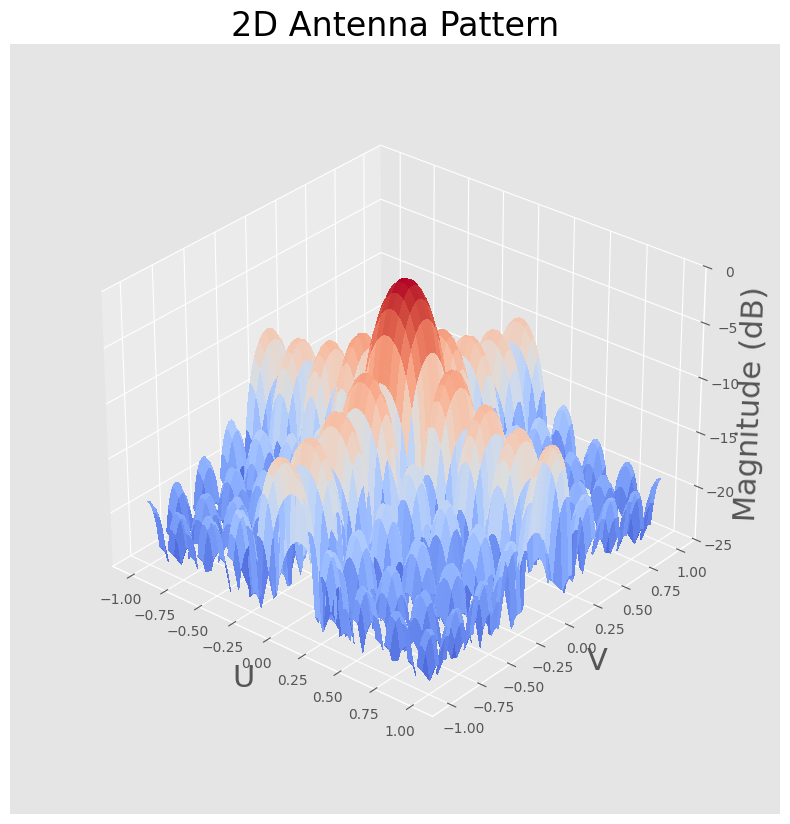

In [ ]:
%matplotlib inline


z_min = -25
z_max = 0

weights_n = np.ones(N)
weights_m = np.ones(M)
AF_rect = compute_af_2d(weights_n, weights_m, d_x,d_y,k_0,u_0,v_0)
AF_rect_log = 10 * np.log10(np.abs(AF_rect))
AF_rect_log_mask = np.where(AF_rect_log > z_min, AF_rect_log, np.nan)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(U, V, AF_rect_log_mask, cmap=cm.coolwarm, antialiased=False)
ax.set_zlim(z_min, z_max)
ax.set_title("2D Antenna Pattern", fontsize=24)
ax.set_xlabel("U", fontsize=22)
ax.set_ylabel("V", fontsize=22)
ax.set_zlabel("Magnitude (dB)", fontsize=22)
ax.view_init(elev=30, azim=-50, roll=0)
ax.set_box_aspect(None, zoom=0.85)
plt.show()

## Taylor taper weighting

![taylor taper design table](https://drive.google.com/uc?id=1ugO_1UXVH8E6ACGy0tCZjY4_5O6ql2QV)

From Mailloux [1]

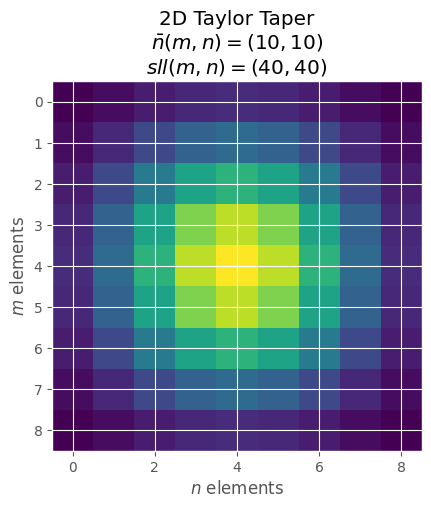

In [ ]:
nbar_n = 10
nbar_m = 10
sll_n = 40
sll_m = 40
window_n = signal.windows.taylor(N, nbar=nbar_n, sll=sll_n)
window_m = signal.windows.taylor(M, nbar=nbar_m, sll=sll_m)

fig, ax = plt.subplots()
ax.set_title(
    f"2D Taylor Taper\n"
    f"$\\bar{{n}}(m,n) = ({nbar_m}, {nbar_n})$\n"
    f"$sll (m,n) = ({sll_m}, {sll_n})$"
)
ax.set_xlabel("$n$ elements")
ax.set_ylabel("$m$ elements")
ax.imshow(np.outer(window_n, window_m))
plt.show()

In [ ]:
AF_taylor = compute_af_2d(window_n, window_m, d_x, d_y, k_0, u_0, v_0)

Note the $z$ scale difference. It may not look *that* different from the previous, but the sidelobes are significantly lower.

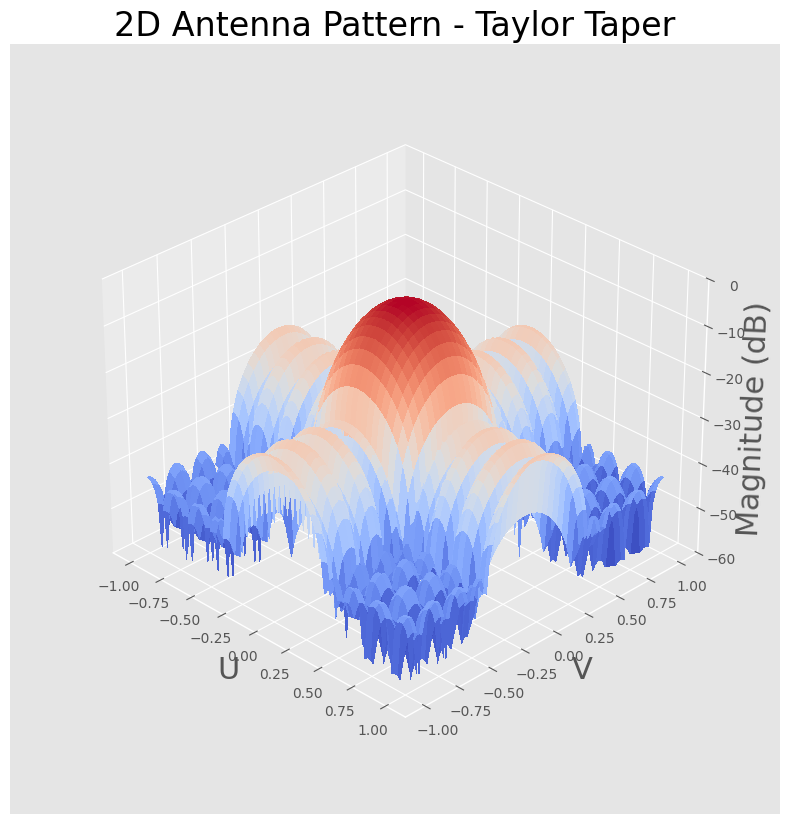

In [ ]:
%matplotlib inline

z_min = -60
z_max = 0


AF_taylor_log = 10 * np.log10(np.abs(AF_taylor))
AF_taylor_log_mask = np.where(AF_taylor_log > z_min, AF_taylor_log, np.nan)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(U, V, AF_taylor_log_mask, cmap=cm.coolwarm, antialiased=False)
ax.set_zlim(z_min, z_max)
ax.set_title("2D Antenna Pattern - Taylor Taper", fontsize=24)
ax.set_xlabel("U", fontsize=22)
ax.set_ylabel("V", fontsize=22)
ax.set_zlabel("Magnitude (dB)", fontsize=22)
ax.view_init(elev=30, azim=-45, roll=0)
ax.set_box_aspect(None, zoom=0.85)
plt.show()